In [5]:
import pandas as pd

# Load the data
df1 = pd.read_csv('train_data.csv')
df2 = pd.read_csv('test_data.csv')
full_data = pd.read_csv('annotations.csv')

# Merge the train and test data
merged_df = pd.concat([df1, df2], ignore_index=True)

# Ensure 'text' column in full_data has unique values
if not full_data['text'].is_unique:
    # Handle duplicates, for example by dropping them
    full_data = full_data.drop_duplicates(subset='text')

# Map the 'source' column from full_data to merged_df based on 'text' column
merged_df['source'] = merged_df['text'].map(full_data.set_index('text')['source'])

merged_df.source.unique()

array(['Anthropic', 'llama3-8b', 'CMV', 'GM', 'Pei', nan], dtype=object)

In [7]:
# show merged_df with source column nans
merged_df[merged_df['source'].isnull()].count()


text             34
assertiveness    34
source            0
dtype: int64

In [8]:
# drop rows with nans in source column
merged_df = merged_df.dropna(subset=['source'])

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 759 entries, 0 to 792
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           759 non-null    object 
 1   assertiveness  759 non-null    float64
 2   source         759 non-null    object 
dtypes: float64(1), object(2)
memory usage: 23.7+ KB


In [11]:
merged_df.to_csv('merged_data.csv', index=False)

In [14]:
import os

# Create a directory for each source
for source in merged_df['source'].unique():
    os.makedirs(source, exist_ok=True)

# Perform leave-one-out training and testing
for source in merged_df['source'].unique():
    # Leave one source out for testing
    test_data = merged_df[merged_df['source'] == source]
    train_data = merged_df[merged_df['source'] != source]

    # Save the train and test data to the respective directories
    train_data.to_csv(f'{source}/train_data.csv', index=False)
    test_data.to_csv(f'{source}/test_data.csv', index=False)

# Check the number of files in each directory
for source in merged_df['source'].unique():
    print(f'{source}: {len(os.listdir(source))}')

Anthropic: 2
llama3-8b: 2
CMV: 2
GM: 2
Pei: 2


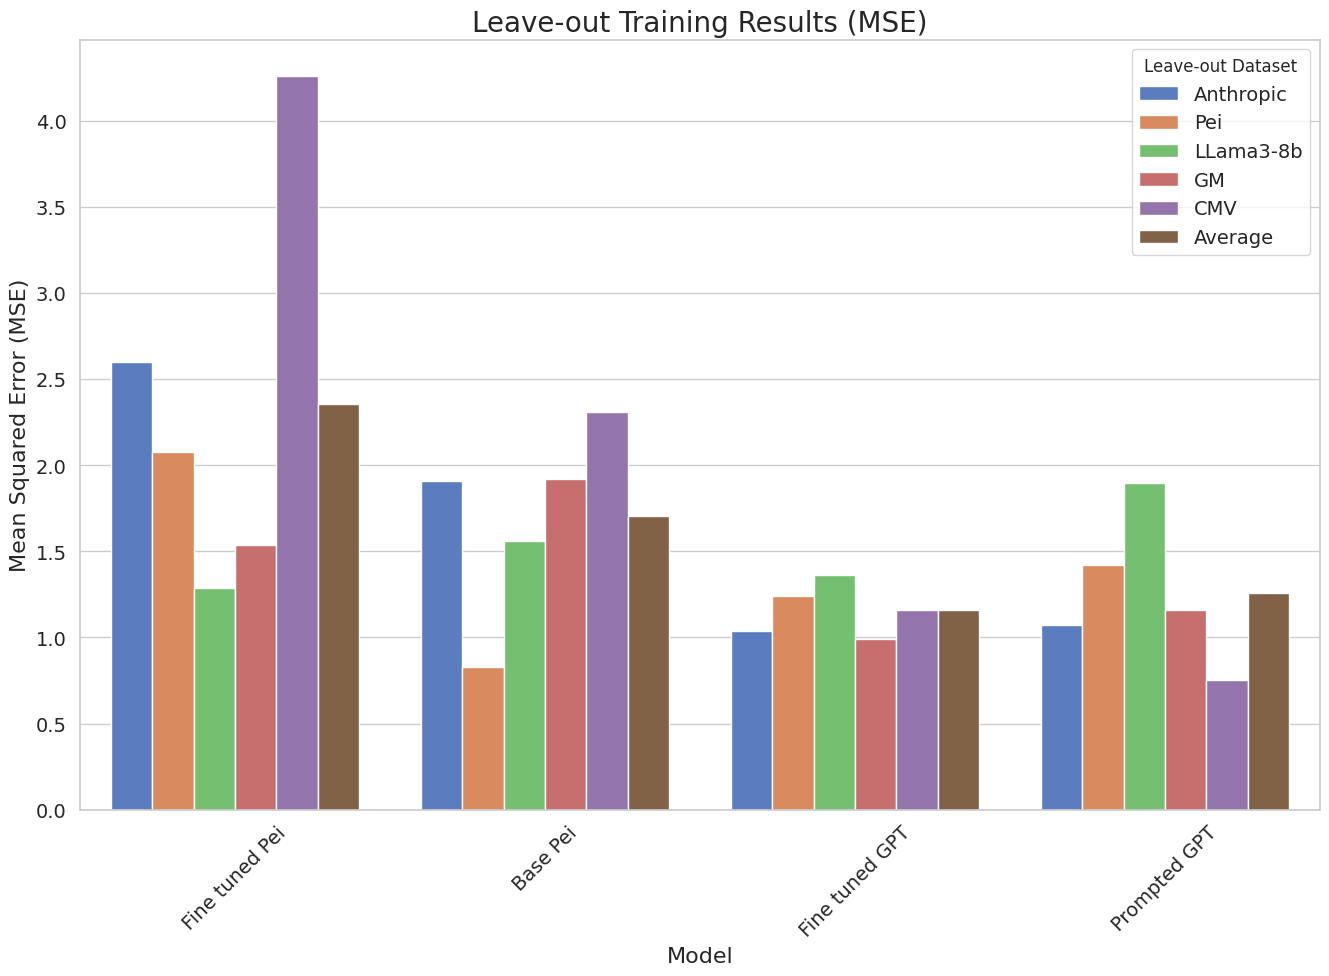

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data
data = {
    'Model': [
        'Fine tuned Pei', 'Fine tuned Pei', 'Fine tuned Pei', 'Fine tuned Pei', 'Fine tuned Pei',
        'Base Pei', 'Base Pei', 'Base Pei', 'Base Pei', 'Base Pei',
        'Fine tuned GPT', 'Fine tuned GPT', 'Fine tuned GPT', 'Fine tuned GPT', 'Fine tuned GPT',
        'Prompted GPT', 'Prompted GPT', 'Prompted GPT', 'Prompted GPT', 'Prompted GPT'
    ],
    'Leave-out': [
        'Anthropic', 'Pei', 'LLama3-8b', 'GM', 'CMV',
        'Anthropic', 'Pei', 'LLama3-8b', 'GM', 'CMV',
        'Anthropic', 'Pei', 'LLama3-8b', 'GM', 'CMV',
        'Anthropic', 'Pei', 'LLama3-8b', 'GM', 'CMV'
    ],
    'MSE': [
        2.6, 2.08, 1.29, 1.54, 4.26,
        1.91, 0.83, 1.56, 1.92, 2.31,
        1.04, 1.24, 1.36, 0.99, 1.16,
        1.07, 1.42, 1.90, 1.16, 0.75
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate average MSE for each model
average_mse = df.groupby('Model')['MSE'].mean().reset_index()
average_mse['Leave-out'] = 'Average'

# Append the average MSE to the original DataFrame
df = pd.concat([df, average_mse], ignore_index=True)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Increase font sizes for better readability
plt.rc('axes', titlesize=20)     # Title font size
plt.rc('axes', labelsize=16)     # X and Y label font size
plt.rc('xtick', labelsize=14)    # X tick label font size
plt.rc('ytick', labelsize=14)    # Y tick label font size
plt.rc('legend', fontsize=14)    # Legend font size

# Create a bar plot
plt.figure(figsize=(16, 10))
ax = sns.barplot(x='Model', y='MSE', hue='Leave-out', data=df, palette='muted')

# Add title and labels
plt.title('Leave-out Training Results (MSE)')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Save the plot with higher resolution
plt.legend(title='Leave-out Dataset')
plt.savefig('leave_out_training_results.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()